Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE     

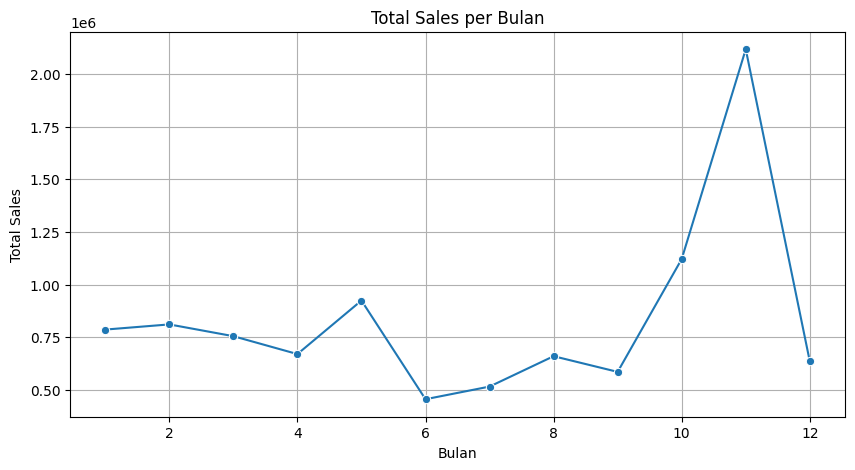

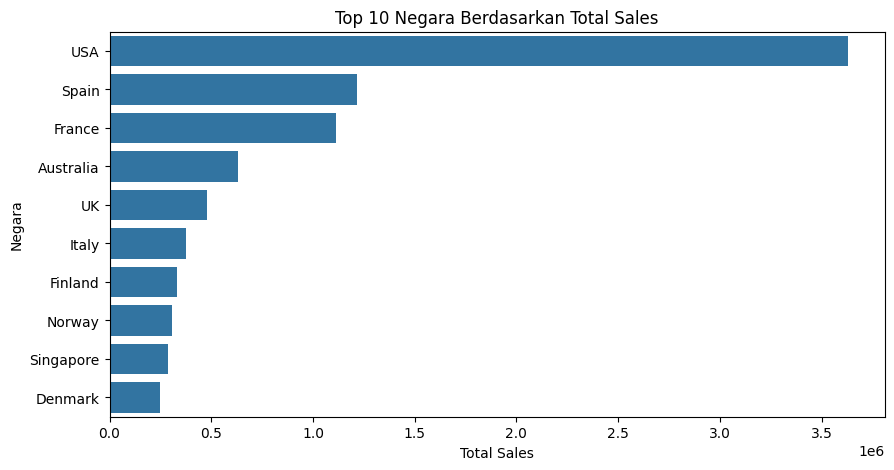

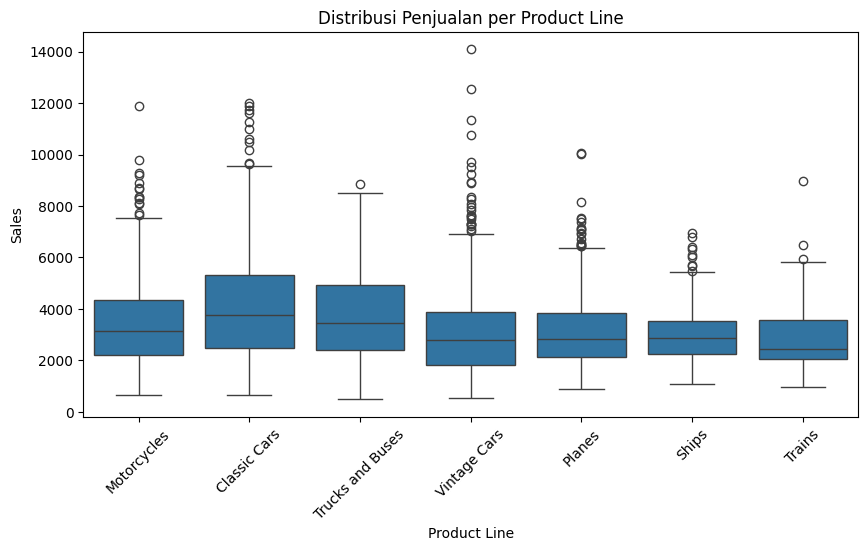

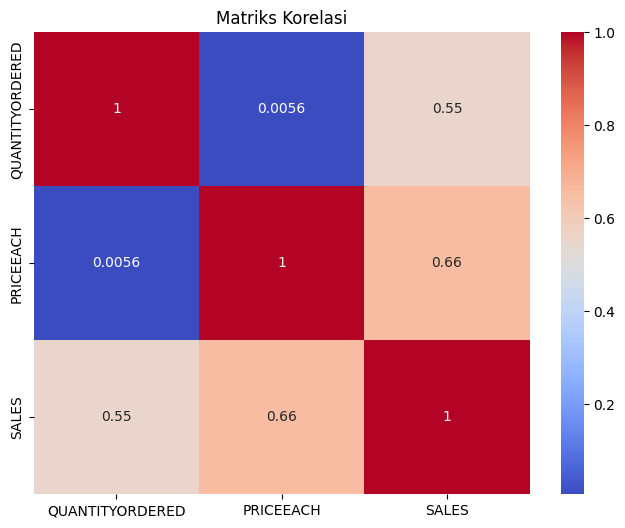

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/sales_data_sample.csv", encoding='latin1')

# Ubah kolom ORDERDATE ke format datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# Info dasar
print("Info Dataset:")
print(df.info())

print("\nStatistik Deskriptif:")
print(df.describe())

print("\nJumlah nilai hilang per kolom:")
print(df.isnull().sum())

# Plot total sales per bulan
df['Month'] = df['ORDERDATE'].dt.month
monthly_sales = df.groupby('Month')['SALES'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Total Sales per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Top 10 negara dengan penjualan tertinggi
country_sales = df.groupby('COUNTRY')['SALES'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title('Top 10 Negara Berdasarkan Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Negara')
plt.show()

# Penjualan berdasarkan Product Line
plt.figure(figsize=(10,5))
sns.boxplot(x='PRODUCTLINE', y='SALES', data=df)
plt.xticks(rotation=45)
plt.title('Distribusi Penjualan per Product Line')
plt.xlabel('Product Line')
plt.ylabel('Sales')
plt.show()

# Korelasi numerik
plt.figure(figsize=(8,6))
sns.heatmap(df[['QUANTITYORDERED', 'PRICEEACH', 'SALES']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()


                  Customer  Recency  Frequency   Monetary R_Score F_Score  \
0           AV Stores, Co.      196          3  157807.81       2       2   
1             Alpha Cognac       65          3   70488.44       4       2   
2       Amica Models & Co.      265          2   94117.26       1       1   
3  Anna's Decorations, Ltd       84          4  153996.13       3       4   
4        Atelier graphique      188          3   24179.96       2       2   

  M_Score RFM_Segment  RFM_Score             Segment  
0       4         224          8     Loyal Customers  
1       2         422          8     Loyal Customers  
2       3         113          5  Potential Loyalist  
3       4         344         11      Best Customers  
4       1         221          5  Potential Loyalist  


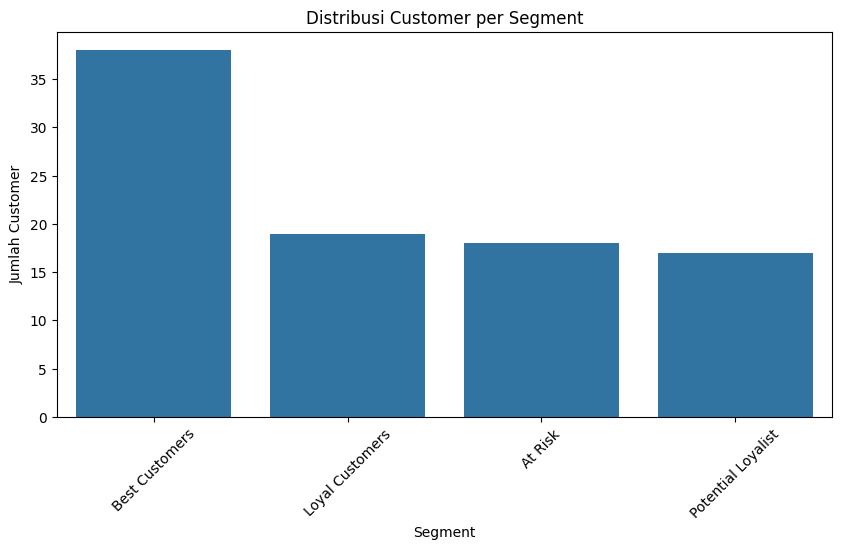

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data
df = pd.read_csv('/content/sales_data_sample.csv', encoding='latin1')
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# Hitung nilai RFM
snapshot_date = df['ORDERDATE'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CUSTOMERNAME').agg({
    'ORDERDATE': lambda x: (snapshot_date - x.max()).days,  # Recency
    'ORDERNUMBER': 'nunique',                                # Frequency
    'SALES': 'sum'                                            # Monetary
}).reset_index()

rfm.columns = ['Customer', 'Recency', 'Frequency', 'Monetary']

# Segmentasi skor (1–4, semakin tinggi semakin baik)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Gabungkan skor jadi segmen
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Tentukan segmen berdasarkan skor
def segment_customer(score):
    if score >= 9:
        return 'Best Customers'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Tampilkan hasil
print(rfm.head())

# Visualisasi jumlah customer per segmen
plt.figure(figsize=(10,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Distribusi Customer per Segment')
plt.xlabel('Segment')
plt.ylabel('Jumlah Customer')
plt.xticks(rotation=45)
plt.show()


<ipython-input-5-3ebcb1c9ae04>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.set_index('ORDERDATE').resample('M')['SALES'].sum()


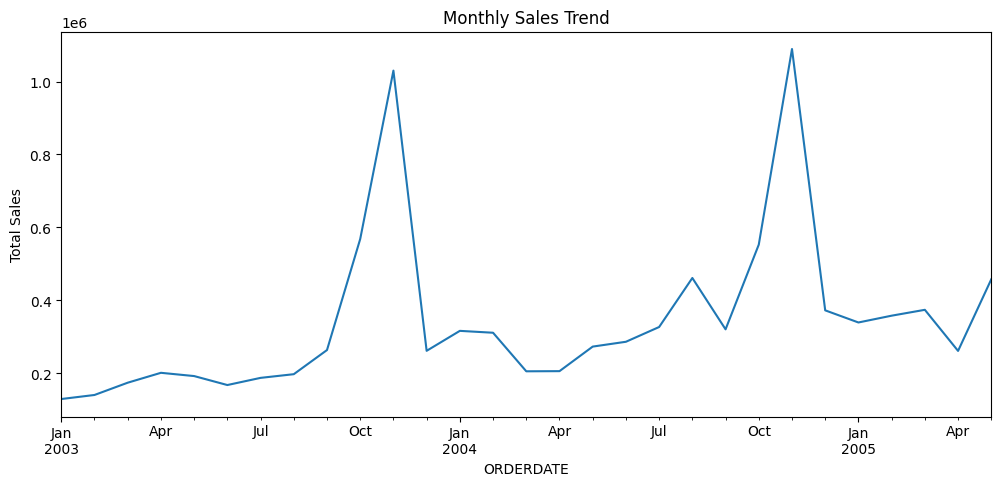

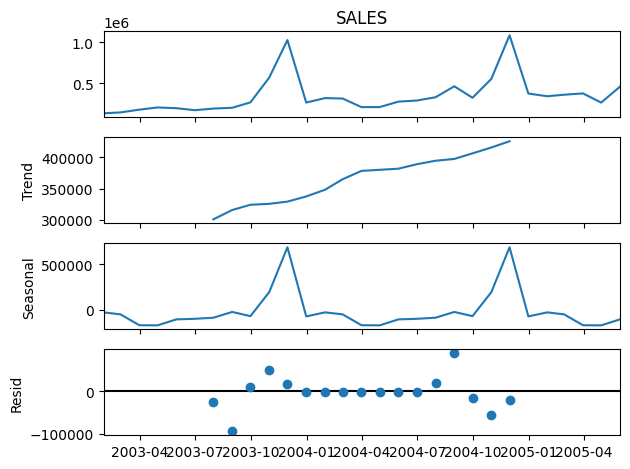

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


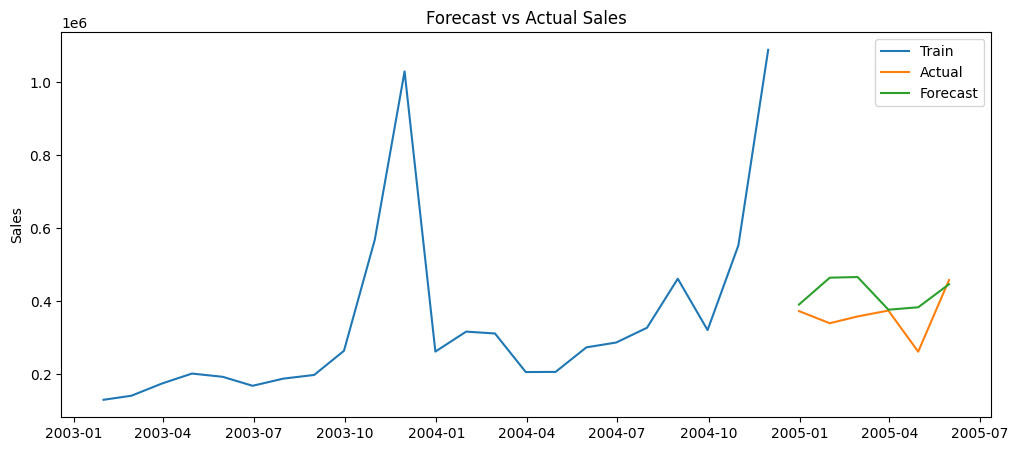

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data
df = pd.read_csv('/content/sales_data_sample.csv', encoding='latin1')
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# Agregasi penjualan per bulan
monthly_sales = df.set_index('ORDERDATE').resample('M')['SALES'].sum()

# Visualisasi tren awal
plt.figure(figsize=(12, 5))
monthly_sales.plot(title='Monthly Sales Trend')
plt.ylabel('Total Sales')
plt.show()

# Decompose (opsional, biar tahu tren/seasonal)
decomposition = seasonal_decompose(monthly_sales, model='additive')
decomposition.plot()
plt.tight_layout()
plt.show()

# Train-test split
train = monthly_sales[:-6]
test = monthly_sales[-6:]

# Build model SARIMA (seasonal ARIMA)
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit()

# Forecast ke depan
forecast = result.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Forecast vs Actual Sales')
plt.ylabel('Sales')
plt.show()


In [ ]:
6import pandas as pd

# Load dataset
df = pd.read_csv('/content/sales_data_sample.csv', encoding='latin1')

# Cek bentuk awal
print("Sebelum dibersihkan:", df.shape)

# 1. Ubah kolom tanggal ke format datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# 2. Drop kolom dengan terlalu banyak nilai kosong (misal > 50%)
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# 3. Tangani nilai kosong yang tersisa
# Untuk data kategori (seperti STATE dan TERRITORY), bisa isi dengan 'Unknown'
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

# Untuk data numerik (seperti POSTALCODE), bisa isi dengan median
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# 4. Hilangkan duplikat jika ada
df = df.drop_duplicates()

# 5. Periksa outlier (optional)
# Contoh: hapus data SALES negatif
df = df[df['SALES'] >= 0]

# 6. Standarisasi teks (misal DEALSIZE atau COUNTRY jadi huruf besar semua)
df['DEALSIZE'] = df['DEALSIZE'].str.upper()
df['COUNTRY'] = df['COUNTRY'].str.upper()

# Cek bentuk akhir
print("Setelah dibersihkan:", df.shape)

# Simpan versi bersih jika perlu
# df.to_csv("sales_data_cleaned.csv", index=False)


Sebelum dibersihkan: (2823, 25)
Setelah dibersihkan: (2823, 23)


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/sales_data_sample.csv", encoding='ISO-8859-1')


# Step 1: Encode target
df_prep = df.copy()
label_enc = LabelEncoder()
df_prep['Target_enc'] = label_enc.fit_transform(df_prep['DEALSIZE'])
print("Target classes:", label_enc.classes_)  # ['Large' 'Medium' 'Small']

# Step 2: Drop kolom tidak relevan atau high-cardinality
drop_cols = ['ORDERNUMBER', 'CUSTOMERNAME', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
             'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE']
df_prep.drop(columns=drop_cols, inplace=True)

# Step 3: Pisahkan fitur dan target
X = df_prep.drop(columns=['DEALSIZE', 'Target_enc'])  # drop target asli dan pakai encoded
y = df_prep['Target_enc']

# Step 4: One-hot encoding fitur kategorikal
categorical_cols = X.select_dtypes(include='object').columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("Jumlah fitur setelah one-hot encoding:", X.shape[1])

# Step 5: Scaling fitur numerik (untuk Logistic Regression)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Step 6: Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Step 7: Cek distribusi
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Distribusi kelas di y_train:\n", y_train.value_counts(normalize=True))


Target classes: ['Large' 'Medium' 'Small']
Jumlah fitur setelah one-hot encoding: 485
Train size: (2258, 485) Test size: (565, 485)
Distribusi kelas di y_train:
 Target_enc
1    0.490257
2    0.453942
0    0.055802
Name: proportion, dtype: float64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -----------------------------
# Model A: Logistic Regression
# -----------------------------
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg, target_names=label_enc.classes_))

# -----------------------------
# Model B: Random Forest
# -----------------------------
# Untuk Random Forest, kita bisa pakai data original (tanpa one-hot) + label encoding
# Tapi di sini kita tetap gunakan data one-hot karena sudah tersedia

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=label_enc.classes_))


=== Logistic Regression ===
Accuracy: 0.9716814159292035
Confusion Matrix:
 [[ 28   3   0]
 [  1 272   4]
 [  0   8 249]]
Classification Report:
               precision    recall  f1-score   support

       Large       0.97      0.90      0.93        31
      Medium       0.96      0.98      0.97       277
       Small       0.98      0.97      0.98       257

    accuracy                           0.97       565
   macro avg       0.97      0.95      0.96       565
weighted avg       0.97      0.97      0.97       565


=== Random Forest ===
Accuracy: 0.9964601769911504
Confusion Matrix:
 [[ 30   1   0]
 [  0 277   0]
 [  0   1 256]]
Classification Report:
               precision    recall  f1-score   support

       Large       1.00      0.97      0.98        31
      Medium       0.99      1.00      1.00       277
       Small       1.00      1.00      1.00       257

    accuracy                           1.00       565
   macro avg       1.00      0.99      0.99       565
weight

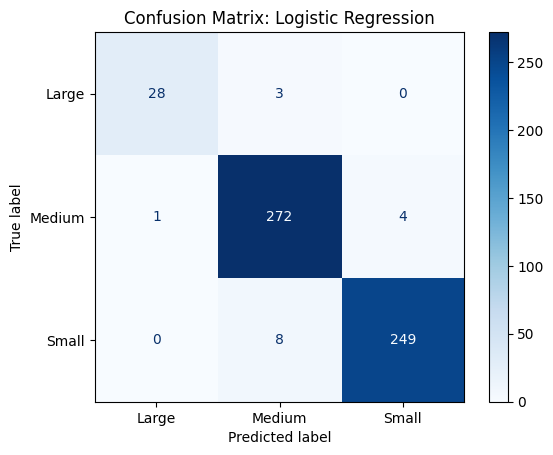

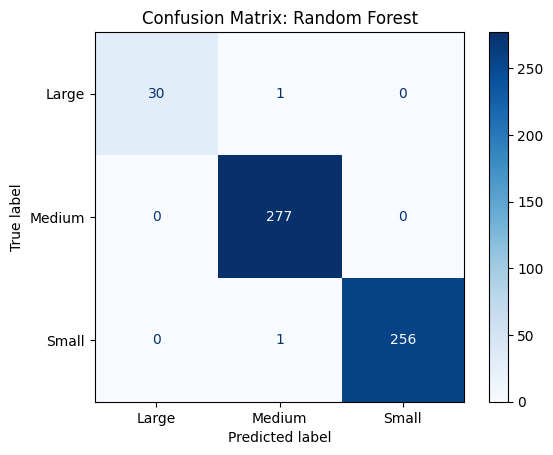

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Fungsi bantu untuk plot confusion matrix
def plot_confusion(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.grid(False)
    plt.show()

# Plot untuk kedua model
plot_confusion("Logistic Regression", y_test, y_pred_logreg)
plot_confusion("Random Forest", y_test, y_pred_rf)


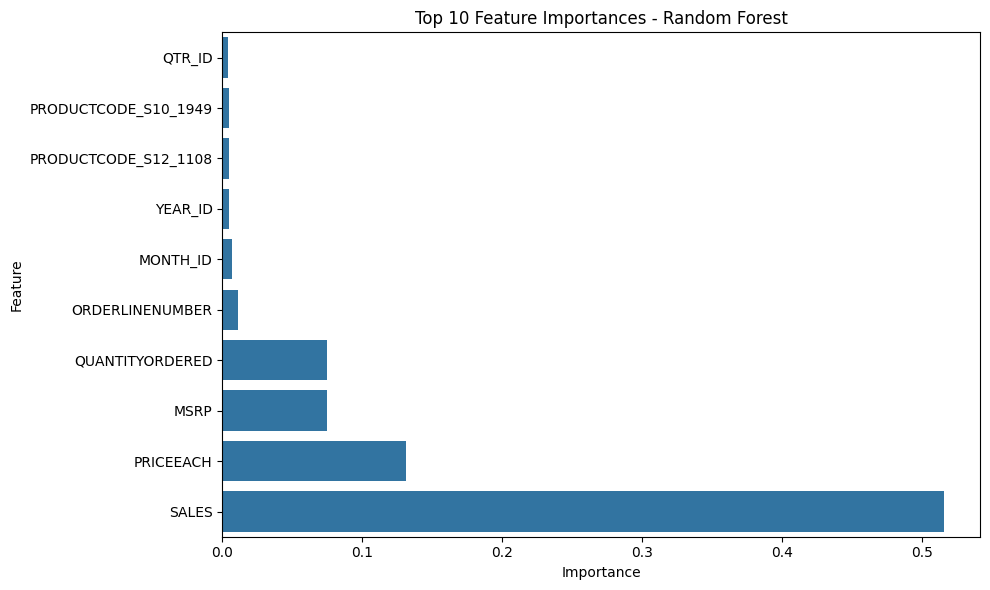

In [ ]:
import numpy as np

# Ambil fitur terpenting
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # ambil 10 fitur paling penting
features = X_train.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances - Random Forest")
sns.barplot(x=importances[indices], y=features)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Get numeric columns from X_train
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), numeric_cols)
], remainder='passthrough')

logreg = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

logreg.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['QUANTITYORDERED',
                                                   'PRICEEACH',
                                                   'ORDERLINENUMBER', 'SALES',
                                                   'QTR_ID', 'MONTH_ID',
                                                   'YEAR_ID', 'MSRP'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)


Model: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Accuracy: 0.9256637168141593
Classification Report:
               precision    recall  f1-score   support

   Cancelled       0.00      0.00      0.00        12
    Disputed       0.00      0.00      0.00         3
  In Process       0.57      0.50      0.53         8
     On Hold       0.00      0.00      0.00         9
    Resolved       0.00      0.00      0.00         9
     Shipped       0.94      0.99      0.96       524

    accuracy                           0.93       565
   macro avg       0.25      0.25      0.25       565
weighted avg       0.88      0.93      0.90       565



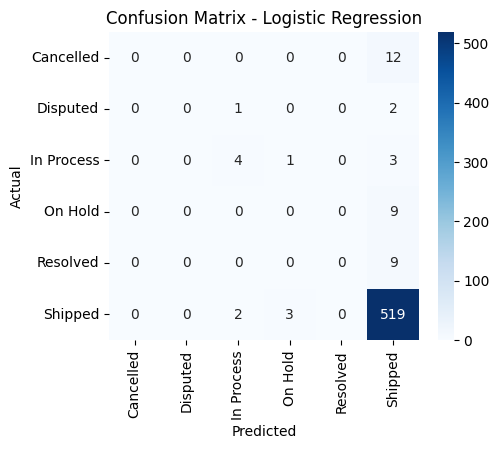


Model: Decision Tree
Accuracy: 0.9946902654867257
Classification Report:
               precision    recall  f1-score   support

   Cancelled       0.85      0.92      0.88        12
    Disputed       1.00      1.00      1.00         3
  In Process       1.00      1.00      1.00         8
     On Hold       1.00      1.00      1.00         9
    Resolved       1.00      1.00      1.00         9
     Shipped       1.00      1.00      1.00       524

    accuracy                           0.99       565
   macro avg       0.97      0.99      0.98       565
weighted avg       0.99      0.99      0.99       565



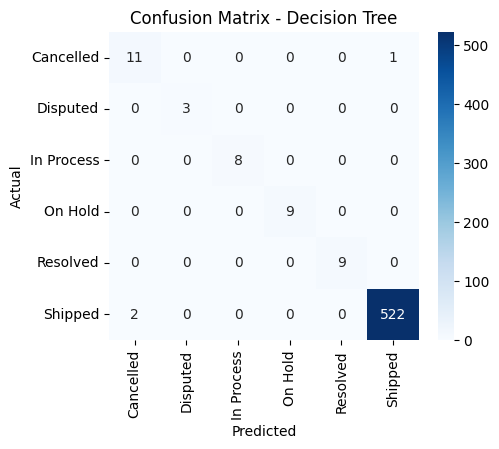


Model: Random Forest
Accuracy: 0.9911504424778761
Classification Report:
               precision    recall  f1-score   support

   Cancelled       1.00      1.00      1.00        12
    Disputed       1.00      0.67      0.80         3
  In Process       1.00      0.88      0.93         8
     On Hold       1.00      0.78      0.88         9
    Resolved       1.00      0.89      0.94         9
     Shipped       0.99      1.00      1.00       524

    accuracy                           0.99       565
   macro avg       1.00      0.87      0.92       565
weighted avg       0.99      0.99      0.99       565



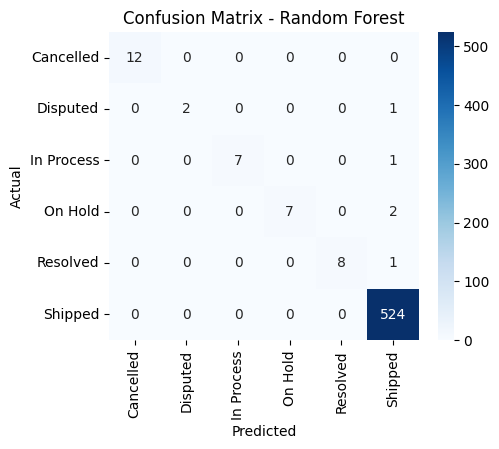


Model: XGBoost
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

   Cancelled       1.00      1.00      1.00        12
    Disputed       1.00      1.00      1.00         3
  In Process       1.00      1.00      1.00         8
     On Hold       1.00      1.00      1.00         9
    Resolved       1.00      1.00      1.00         9
     Shipped       1.00      1.00      1.00       524

    accuracy                           1.00       565
   macro avg       1.00      1.00      1.00       565
weighted avg       1.00      1.00      1.00       565



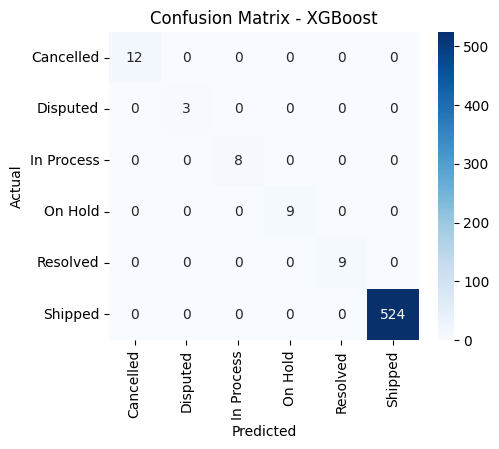

In [12]:
# Import library
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assuming 'df' is your DataFrame and 'STATUS' is your target variable
# You might need to adjust the feature columns and target variable based on your actual data
X = df.drop(['STATUS', 'ORDERDATE'], axis=1)  # Features
y = df['STATUS']  # Target

# Encode the target variable if it's categorical
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)

# Perform one-hot encoding for categorical features
X = pd.get_dummies(X)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# List model yang akan diuji
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Training dan evaluasi
for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluasi
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_enc.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()